In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
import serbian_stemmer

In [2]:
data = pd.read_excel('data/full_data.xlsx',sheet_name='Sheet1')

In [3]:
with open('serbian_stopwords.txt') as f:
    lines = f.readlines()
stopwords = []
for line in lines:
    stopwords.append(line[:-1])

Removing reviews without a grade:

In [4]:
missing = 100*(data[data.Rating == 0].shape[0])/(data.shape[0])
print('Percentage of reviews without a grade: %.2f' % missing + '%')
data = data[data.Rating > 0]

Percentage of reviews without a grade: 2.18%


Creating a label:

In [5]:
data["Label"] = 0
data.loc[data.Rating >= 3.5,["Label"]] = 1
data[['Rating','Label']].describe().transpose().drop('count',axis=1)  

,mean,std,min,25%,50%,75%,max
Rating,4.444125,0.891965,1.0,4.3,4.8,5.0,5.0
Label,0.889035,0.314091,0.0,1.0,1.0,1.0,1.0


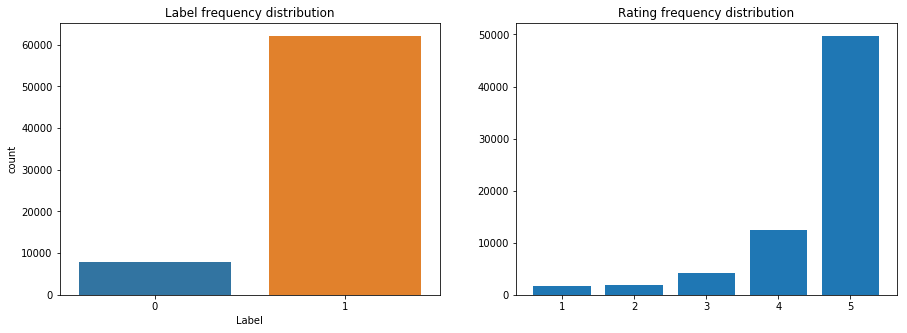

In [6]:
rating_distribution = { 1: data[data.Rating < 1.5].shape[0],
                        2: data[(data.Rating >= 1.5) & (data.Rating < 2.5)].shape[0],
                        3: data[(data.Rating >= 2.5) & (data.Rating < 3.5)].shape[0],
                        4: data[(data.Rating >=3.5) & (data.Rating < 4.5)].shape[0],
                        5: data[data.Rating >= 4.5].shape[0]
                      }
plt.figure(figsize=(15, 5))   
plt.subplot(121)
plt.title('Label frequency distribution')
sns.countplot(data.Label)
plt.subplot(122)
plt.bar(rating_distribution.keys(),rating_distribution.values())
plt.title('Rating frequency distribution')
plt.show()

As we can see vast majority of reviews has high score.

In [7]:
data["Title Character Count"] = data['Title'].str.len()
data["Review Character Count"] = data['Content'].str.len()
data[['Title Character Count','Review Character Count']].describe().transpose().drop('count',axis=1)

,mean,std,min,25%,50%,75%,max
Title Character Count,11.563718,8.435788,1.0,6.0,9.0,15.0,133.0
Review Character Count,91.168075,127.955246,1.0,18.0,48.0,112.0,2215.0


In [8]:
tokenizer = RegexpTokenizer(r'\w+')
data['Tokenized Title'] = data['Title'].str.lower().str.strip().str.split('[\W_]+')
data['Tokenized Review'] = data['Content'].str.lower().str.strip().str.split('[\W_]+')

data.dropna(subset=['Tokenized Title','Tokenized Review'],inplace=True)

data['Title Word Count'] = data['Tokenized Title'].apply(len)
data['Review Word Count'] = data['Tokenized Review'].apply(len)

In [9]:
data[['Title Word Count','Review Word Count']].describe().transpose().drop('count',axis=1)

,mean,std,min,25%,50%,75%,max
Title Word Count,2.080123,1.403208,1.0,1.0,2.0,3.0,21.0
Review Word Count,16.105685,22.390011,1.0,3.0,9.0,20.0,419.0


In [10]:
# def remove_diacritics(text):
#     text = text.replace('ć','c')
#     text = text.replace('č','c')
#     text = text.replace('š','s')
#     text = text.replace('ž','z')
#     text = text.replace('đ','d')
#     return text

def preprocess(words):
    result = [w.lower() for w in words]
    result = [serbian_stemmer.stem(w) for w in result if w not in stopwords]
    return result

data['Processed Title'] = data['Tokenized Title'].apply(lambda x : preprocess(x)) 
data['Processed Review'] = data['Tokenized Review'].apply(lambda x : preprocess(x)) 

In [11]:
empty_reviews = data[np.logical_and(data['Processed Title'].apply(len) == 0,data['Processed Review'].apply(len) == 0)]
print('Number of empty reviews(both title and content of review) after removing stopwords: {}'.format(empty_reviews.shape[0]))
empty_reviews[['Title','Content','Label']]

Number of empty reviews(both title and content of review) after removing stopwords: 54


,Title,Content,Label
4645,ja,ja,0
4650,A,A,1
4904,A,A,1
5930,a,a,1
6419,a,a,1
6482,A,A,1
8664,A,A,0
9333,A,A,1
10141,a,a,1
10339,S,S,1


These reviews have no semantic value, therefor they will be removed from dataset:

In [12]:
data = data[np.logical_or(data['Processed Title'].apply(len) > 0,data['Processed Review'].apply(len) > 0)]

In [20]:
data[['Title','Content','Processed Title','Processed Review']].head()

,Title,Content,Processed Title,Processed Review
0,odlicne pice,Odrzavaju odlican kvalitet.,"[odlicn , pic ]","[odrzava , odlican , kvalitet , ]"
1,Rostilj,kvalitetno i brzo,[rostilj ],"[kvalitetn , brz ]"
2,Spek pica,Fenomenalna kombinacija za ljubitelje jakih uk...,"[spek , pic ]","[fenomenaln , kombinacij , ljubitelj , jak , u..."
3,super su,za prvi put sve ok!,[super ],"[ok , ]"
4,super,super su,[super ],[super ]


In [27]:
print('Number of empty reviews with positive label:',empty_reviews[empty_reviews['Label'] == 1].shape[0])
print('Number of empty reviews with negative label:',empty_reviews[empty_reviews['Label'] == 0].shape[0])

Number of empty reviews with positive label: 50
Number of empty reviews with negative label: {} 4


In [19]:
empty_reviews[empty_reviews['Label']==0]

,User,Title,Content,Rating,Published,Food Quality,Food Choice,Prices,Service,Label,Title Character Count,Review Character Count,Tokenized Title,Tokenized Review,Title Word Count,Review Word Count,Processed Title,Processed Review
4645,VojkanD4,ja,ja,3.3,2019-02-24,5.0,3.0,2.0,3.0,0,2.0,2.0,[ja],[ja],1,1,[],[]
8664,Vojo2,A,A,3.0,2017-07-01,2.0,2.0,5.0,3.0,0,1.0,1.0,[a],[a],1,1,[],[]
39594,veliki.Lale,A,A,3.3,2019-01-22,3.0,3.0,3.0,4.0,0,1.0,1.0,[a],[a],1,1,[],[]
52885,Darko307,a,a,3.0,2018-04-27,3.0,3.0,3.0,3.0,0,1.0,1.0,[a],[a],1,1,[],[]


As we can see majority of reviews without a content after preprocessing have positive label. Even the ones with negative label are somewhat close to being positive.